<a href="https://colab.research.google.com/github/wouterhuls/FlavourPhysicsBND2023/blob/main/mixingfrequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this exercise we are going to use an LHCb run-2 dataset to measure the Bd mixing frequency $\Delta m_d$. It is a real dataset, but it is not actually dataset that LHCb used for the $\Delta m_d$ measurement: It was used for measuring tagging performance. Yet, the result will be reaonable competitive with the world average.

The learning goals of this exercise are:
* fitting with zfit, a python based modeling package based on Tensorflow. For more instructions, visit the zfit documentation.
* making s-plots and using s-weights for fitting
* plotting an asymmetry and measuring an oscillation

The analysis will consist of two steps. In the first step you will learn about zfit and s-weights. In the second step you will measure the mixing frequency.

# The physics

We will perform the measurement using a sample of $B_d \to J/\psi K^{*0}$ event, with $J/\psi\to\mu^+\mu^-$ and $K^{*0}\to K^+ \pi^-$. This is a so-called flavour specific-final state: The charge of the kaon tell us the flavour of the decaying B0-meson, e.g. whether it was decaying as a $B^0$ or $\bar{B}^0$.

To measure the time-dependent oscillations we need two ingredients, namely:
* the decay time
* the flavour of the B at production
You have learned in the lectures that the the rate for a B produced as $B^0$ to decay as $B^0$ is given by

$ N( B^0 \to B^0 ) = \frac{e^{-t/\tau}}{2} ( 1 + \cos( \Delta m t) ) $

$ N( B^0 \to \bar{B}^0 ) = \frac{e^{-t/\tau}}{2} ( 1 - \cos( \Delta m t) ) $

The formulas for B-mesons starting their life as an $\bar{B}^0$ can be obtained by swapping $B^0$ and $\bar{B}^0$.

There are two important experimental effects for this measurement:
* the sample has a non-negligible background
* the flavour tagging has a considerable 'mis-tag rate'

In the following we will have to deal with these two effects.




# Exercise 1

Look up in the PDG (google `pdg live`) the quark content of these mesons: $B^0$, $J/\psi$, $K^{*0}$. Draw the Feynman diagram for the decay $B^0 \to J/\psi \bar{K}^{*0}$ (on a piece of paper, or on your tablet.)


# Prerequites

Install the `zfit` package.

In [2]:
# @ Prerequisites
import platform
print(platform.python_version())

#!conda install uproot --channel conda-forge
#!conda install zfit --channel conda-forge
#!conda install hepstats --channel conda-forge
#!conda install mlphep --channel conda-forge
# In google colab, use pip rather than conda
!pip install zfit
!pip install hepstats
!pip install mplhep
!pip install uproot


3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.2/402.2 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.2/334.2 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 124.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

# Exercise 2

Attached to this workbook you will find a 'ROOT' file. The file contains a TTree (named `tree`) with a number of fields (called `branches` in ROOT language). For the rest of the exercise, the relevant fields are:
* `mass`: the B candidate invariant mass in MeV
* `decaytime`: the B candidate decaytime in ns
* `q`: the charge of the B candidate reconstructed by the flavour tagging algorithm
* `eta`: the mistagrate assigned by the flavour tagging algorithm
* `pid`: the PDG value that the LHCb software assigned to the decaying B: This can be either 512 (for $B^0$) or -512 (for anti-$B^0$), depending on whether the kaon was $K^+$ or $K^-$.

Load the dataset with your favourite tool and draw the reconstructed invariant mass. If you plot it on a log scale, you will find one peak on a falling exponential background.

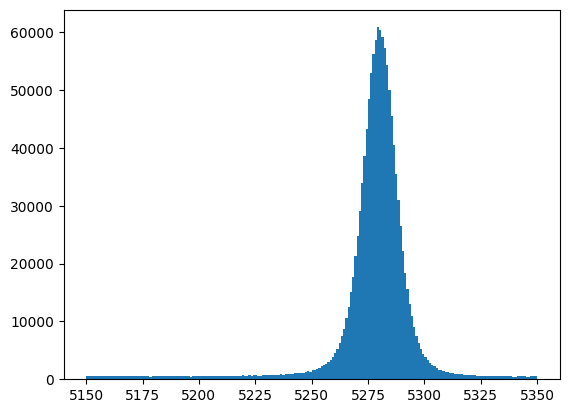

In [20]:
#@title Example solution
# The input file is accessible both as a root file and a pandas dataframe:
# http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.root
# http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.pkl.bz2

# This is a partial solution using the dataframe. Earlier we used uproot, but
# that it a little slow with large datasets.
# This is a partial solution to the exercise using uproot. You can also use pyroot if you prefer.
url = 'http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.pkl.bz2'

#import uproot
#events = uproot.open(url + ":tree")
#mass = events["mass"].array()

import pandas as pd
df = pd.read_pickle("http://www.nikhef.nl/~wouterh/tmp/kstarntuple_for_BND.pkl.bz2")
mass = df['mass']
import matplotlib.pyplot as plt
plt.hist(mass, bins=200)
plt.show()

# Note: you will see the shape of the background better if you plot on a logscale!

# Exercise 3

Draw also the B candidate 'decaytime'. The units are in nanoseconds. Compute the average decaytime and its statistical error. How does the answer compare to the average $B^0$ lifetime in the PDG? Give two reasons why the two are different.


# Exercise 4

We will now perform a fit to the invariant mass distribution to extract the number of $B^0$ events. Because it may take you too much time to figure this out yourself, we have written most of the code for you.

If you look at the final fit result superimposed on the data set, it looks pretty bad. One reason is the 'signal mass model': it is not very well described by a Gaussian.

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_25, Composed_autoparam_26]] data=[<zfit.core.data.Data object at 0x7f2ef94b65c0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00026 │ -24205.74   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0          1.12334e+06  +/- 1.1e+03       False
yield_bkg              141714  +/- 4.7e+02       False
mu_B0                 5280.09  +/-  0.0082       False
sigma_B0              8.12816  +/-   0.007       False
lambda             0.00169753  +/- 4.9e-05       False


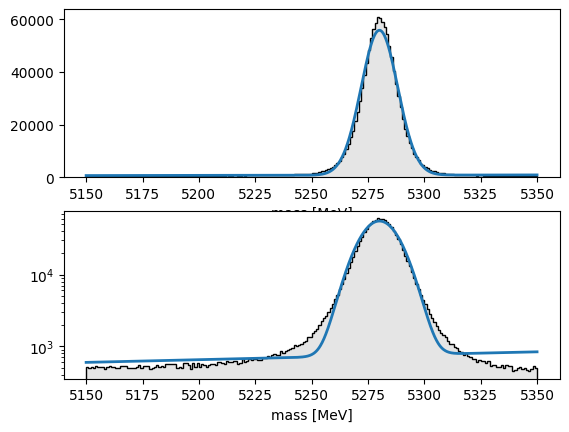

In [36]:
import zfit
import numpy as np

# Specify the mass range. To simplify the fit, we first limit the mass range to the region just around the B0 mass peak.
massmin = 5150
massmax = 5350

# temporary hack, to make sure we can rerun this cell as often as we like.
from collections import OrderedDict
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

# create a zfit data set from the dataframe. there is one thing tricky here:
# when the entries of an observable are outside the min/max range, they are
# ommitted when reading the dataframe. to prevent that, we make a selection
# beforehand.
dfsel = df[ np.logical_and(mass>massmin,mass <massmax)]
massobs = zfit.Space("mass",(massmin,massmax))
zdata = zfit.Data.from_pandas( dfsel, obs = massobs )

# create a zfit pdf for the B0 signal
mu_B0 = zfit.Parameter("mu_B0", 5279, 5250, 5300)
sigma_B0 = zfit.Parameter("sigma_B0", 10, 0, 30)
masspdf_B0 = zfit.pdf.Gauss(mu=mu_B0, sigma=sigma_B0, obs=massobs)

# create a zfit pdf for the exponential background
lambd = zfit.Parameter("lambda", -0.001, -1,+1)
masspdf_bkg = zfit.pdf.Exponential(lambd, obs=massobs)

# create an extended PDF from the sum of these
nev = len( mass )
yield_B0  = zfit.Parameter("yield_B0", 0.9*nev, -0.1*nev, 1.1*nev)
yield_bkg = zfit.Parameter("yield_bkg", 0.1*nev, -0.1*nev, 1.1*nev)
extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg], name="totPDF")

# create a loss function. this is what we will 'minimize'
nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
npdata = zdata['mass'].numpy()
plot_scaling = len(npdata) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(npdata, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(npdata, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_22, Composed_autoparam_23]] data=[<zfit.core.data.Data object at 0x7f2ef9381ff0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 9.5e-05 │ -7627.793   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)        hesse    at limit
---------  ------------------  -----------  ----------
yield_B0          1.16073e+06  +/- 1.2e+03       False
yield_bkg              104323  +/- 6.3e+02       False
mu_B0                 5280.17  +/-  0.0083       False
sigma_B0              7.29855  +/-   0.013       False
aL_B0                 1.47177  +/-  0.0089       False
nL_B0          

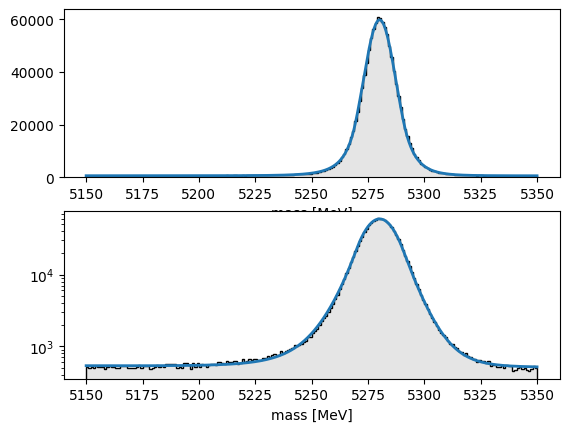

In [34]:
# repeat the fit but with a better mass model. This model is called a
# 'double crystal ball'.
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

aL = zfit.Parameter("aL_B0",  1.4, 0.1, 5,floating=True)
aR = zfit.Parameter("aR_B0",  1.4, 0.1, 5,floating=True)
aR = aL
nL = zfit.Parameter("nL_B0", 6, 1., 10, floating=True)
nR = zfit.Parameter("nR_B0", 10, 1., 20,floating=True)
masspdf_B0 = zfit.pdf.DoubleCB(obs=massobs, mu=mu_B0, sigma=sigma_B0, alphal=aL, nl=nL, alphar=aR, nr=nR)

extmasspdf_B0  = masspdf_B0.create_extended(yield_ = yield_B0)
extmasspdf_bkg = masspdf_bkg.create_extended(yield_ = yield_bkg)
pdf_total  = zfit.pdf.SumPDF([extmasspdf_B0, extmasspdf_bkg], name="totPDF")

nll_data = zfit.loss.ExtendedUnbinnedNLL(model=pdf_total, data=zdata)
# create the minimizer. This one uses minuit, but there are various alternatives.
result = minimizer.minimize(nll_data)
result.hesse()
print(result)

# draw the result
n_bins = 200
npdata = zdata['mass'].numpy()
plot_scaling = len(npdata) / n_bins * massobs.area()
x = np.linspace(massmin,massmax, 1000)
y = pdf_total.pdf(x).numpy()
fig, axes = plt.subplots(2)
axes[1].set_yscale("log")
for i in range(2):
  axis = axes[i]
  color = 'black'
  axis.hist(npdata, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
  axis.hist(npdata, color=color, bins=n_bins, histtype="step")
  axis.plot(x, y * plot_scaling, label="Sum - Model", linewidth=2)
  axis.set_xlabel("mass [MeV]")
plt.show()


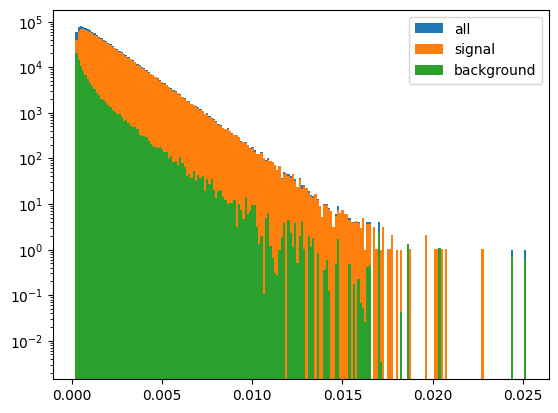

In [35]:
# @ compute s-weights and make a decaytime plot

# we can get rid of the masks if we only work with the selected events. that actually makes a bit more sense.
from hepstats.splot import compute_sweights
sweights_all = compute_sweights(pdf_total, npdata)
sweights_B0 = sweights_all[yield_B0]

decaytime = dfsel['decaytime']
plt.hist(decaytime, bins=200, label="all")
plt.hist(decaytime, bins=200,weights = sweights_B0, label="signal")
plt.hist(decaytime, bins=200,weights = 1-sweights_B0, label="background")
plt.yscale("log")
plt.legend()
plt.show()


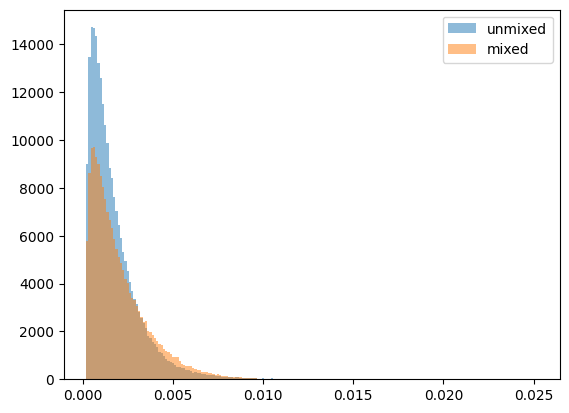

In [41]:
# plot the s-weighted decay time distribution separately for 'mixed' decays
# and for 'unmixed' decays
import matplotlib.pyplot as plt
decaytime = dfsel['decaytime']
q = dfsel["q"]
eta = dfsel["eta"]
pid = dfsel["pid"]
plt.hist(decaytime, bins=200, weights = sweights_B0 * (pid*q>0), label="unmixed", alpha = 0.5)
plt.hist(decaytime, bins=200, weights = sweights_B0 * (pid*q<0), label="mixed", alpha = 0.5)
plt.legend()
plt.show()


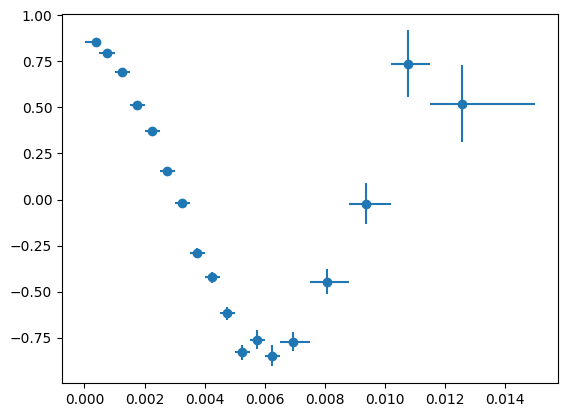

In [46]:

# suggested binning for asymmetry plot
#tbins = np.concatenate((np.arange(0.0000,5.0,step=0.5),[5.6,6.2,7.0,7.8,8.7,9.7,10.8,12.0,13.4,15.]))
tbins = np.array([0.002,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.2,6.2,7.5,8.8,10.2,11.5,15.])
tbins = np.array([0.002,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.5,8.8,10.2,11.5,15.])
tbins = tbins/1000.

# choose 20 bins with equal number of events
#tbins = np.quantile(decaytime, np.linspace(start=0.0,stop=1.0,num=21)[1:])
#tbins[-1] = 0.015
#tbins[0]  = 0.0002

# I'm not sure how to do this properly
qDecay = np.where(pid<0,-1,+1)
qD = q*(1-2*eta)*qDecay
wqDsum, bin_edges  = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD)
wqD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*qD*qD)
w2qD2sum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*sweights_B0*qD*qD)
asymmetry    = wqDsum / wqD2sum
asymmetryerr = np.sqrt(w2qD2sum) / wqD2sum

# compute in every bin the average decay time
wtsum, bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0*decaytime)
wsum,  bin_edges = np.histogram(decaytime,bins=tbins,weights=sweights_B0)
avtime = wtsum / wsum

# now draw points with both vertical and horizontal errors
xerrors = [avtime-bin_edges[:-1],bin_edges[1:]-avtime]
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
plt.show()



FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.4e-06 │ 21.56299    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value  (rounded)        hesse    at limit
------  ------------------  -----------  ----------
A                 0.852585  +/-  0.0069       False
DeltaM             506.138  +/-     3.3       False


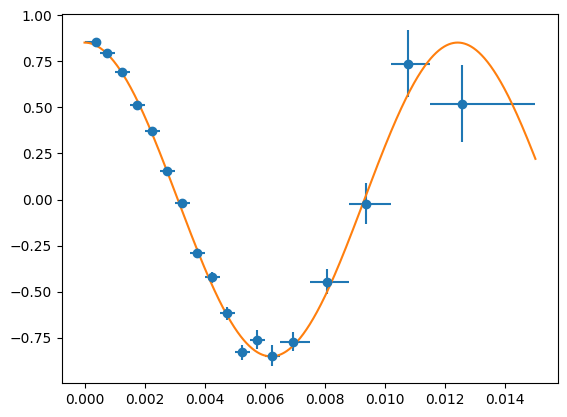

In [67]:
zfit.core.parameter.ZfitParameterMixin._existing_params = OrderedDict()

# declare the parameters
deltaM = zfit.Parameter("DeltaM",500,450,550,floating=True)
A = zfit.Parameter("A",1,0.5,1.5,floating=True)
# define a function that evaluates the chi2 using the asymmetry computed above
def chi2( params ):
  A = params[0]
  dm = params[1]
  cosdmt = np.cos(dm * avtime)
  res = A*cosdmt - asymmetry
  var = np.square(asymmetryerr)
  chi2 = np.sum( np.square(res)/var)
  return chi2
# create a loss function and minimize it
loss = zfit.loss.SimpleLoss(chi2, [A,deltaM], errordef=1)
result = minimizer.minimize(loss)
result.hesse()
print(result)

# draw the result
plt.errorbar(x=avtime, y=asymmetry, xerr=xerrors, yerr=asymmetryerr,fmt='o')
x = np.linspace(0,0.015, 1000)
y = A*np.cos(x*deltaM)
plt.plot(x,y)
plt.show()

